In [31]:
import cv2
import os
import numpy as np
from src.utils.utils import *

In [32]:
current_directory = os.getcwd()
while not current_directory.endswith('pneumonia_detection'):
    current_directory = os.path.dirname(current_directory)
root_directory = current_directory
os.chdir(root_directory)   
DATA_DIR = os.path.join(root_directory, 'data_processed')

## Check number of files in train, test, and validation sets

### Check number of files in train sets

In [33]:
normal_lungs = [[], [] , []]
pneumonia_lungs = [[], [], []]

In [34]:
data_paths = {
    'train': {
        'NORMAL': os.path.join(DATA_DIR, 'train', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'train', 'PNEUMONIA')
    },
    'val': {
        'NORMAL': os.path.join(DATA_DIR, 'val', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'val', 'PNEUMONIA')
    },
    'test': {
        'NORMAL': os.path.join(DATA_DIR, 'test', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'test', 'PNEUMONIA')
    }
}

In [35]:
file_names = {
    'train': {
        'NORMAL': [],
        'PNEUMONIA': []
    },
    'val': {
        'NORMAL': [],
        'PNEUMONIA': []
    },
    'test': {
        'NORMAL': [],
        'PNEUMONIA': []
    }
}

In [36]:
file_names['train']['NORMAL'] = list_folder(data_paths['train']['NORMAL'])
file_names['train']['PNEUMONIA'] = list_folder(data_paths['train']['PNEUMONIA'])
len(file_names['train']['NORMAL']) , len(file_names['train']['PNEUMONIA'])

(4023, 3875)

### Check number of files in val sets

In [37]:
file_names['val']['NORMAL'] = list_folder(data_paths['val']['NORMAL'])
file_names['val']['PNEUMONIA'] = list_folder(data_paths['val']['PNEUMONIA'])
len(file_names['val']['NORMAL']) , len(file_names['val']['PNEUMONIA'])

(8, 8)

### Check number of files in test sets

In [38]:
file_names['test']['NORMAL'] = list_folder(data_paths['test']['NORMAL'])
file_names['test']['PNEUMONIA'] = list_folder(data_paths['test']['PNEUMONIA'])
len(file_names['test']['NORMAL']) , len(file_names['test']['PNEUMONIA'])

(234, 390)

### Dataset Distribution Summary
| Split | NORMAL | PNEUMONIA | Total |
|-------|--------|-----------|-------|
| Train | 1,341  | 3,875     | 5,216 |
| Val   | 8      | 8         | 16    |
| Test  | 234    | 390       | 624   |

**Note:** The dataset is imbalanced with ~3x more PNEUMONIA samples than NORMAL in the training set.

### Data Augmentation for NORMAL Training Samples
To address class imbalance, we create 2 augmented versions of each NORMAL training sample:
1. **Horizontal Flip** - Mirror the image horizontally
2. **Random Translation** - Shift the image randomly within ±10% of image dimensions

This will increase NORMAL training samples from 1,341 to 4,023 (1,341 original + 2,682 augmented), closer to the 3,875 PNEUMONIA samples.

In [39]:
import random

def horizontal_flip(image):
    """Flip image horizontally"""
    return cv2.flip(image, 1)

def random_translation(image, max_shift_ratio=0.1):
    """Randomly translate image within ±max_shift_ratio of image dimensions"""
    h, w = image.shape[:2]
    max_shift_x = int(w * max_shift_ratio)
    max_shift_y = int(h * max_shift_ratio)
    
    tx = random.randint(-max_shift_x, max_shift_x)
    ty = random.randint(-max_shift_y, max_shift_y)
    
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(image, translation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    return translated

In [40]:
train_normal_path = os.path.join(DATA_DIR, 'train', 'NORMAL')
normal_files = list_folder(train_normal_path)

delete_aug_files = True
if delete_aug_files:    
    for file_name in normal_files:
        if '_flip' in file_name or '_trans' in file_name:
            file_path = os.path.join(train_normal_path, file_name)
            os.remove(file_path)
            
normal_files = list_folder(train_normal_path)

In [41]:
## AUGMENT NORMAL TRAINING SAMPLES FROM PREPROCESSED DATA
augmented_count = 0
images_to_show = []

for file_name in normal_files:
    file_path = os.path.join(train_normal_path, file_name)
    
    # Read preprocessed image
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: Unable to read image file at {file_path}")
        continue
    
    base_name = os.path.splitext(file_name)[0]
    ext = os.path.splitext(file_name)[1]
    
    # 1. Horizontal flip
    flipped = horizontal_flip(image)
    cv2.imwrite(os.path.join(train_normal_path, f"{base_name}_flip{ext}"), flipped)
    
    # 2. Random translation
    translated = random_translation(image)
    cv2.imwrite(os.path.join(train_normal_path, f"{base_name}_trans{ext}"), translated)
    
    if augmented_count < 6:
        images_to_show.extend([image, flipped, translated])
    
    augmented_count += 2

print(f"Augmentation complete!")
print(f"Original NORMAL training samples: {len(normal_files)}")
print(f"Augmented samples created: {augmented_count}")
print(f"Total NORMAL training samples: {len(normal_files) + augmented_count}")

Augmentation complete!
Original NORMAL training samples: 1341
Augmented samples created: 2682
Total NORMAL training samples: 4023


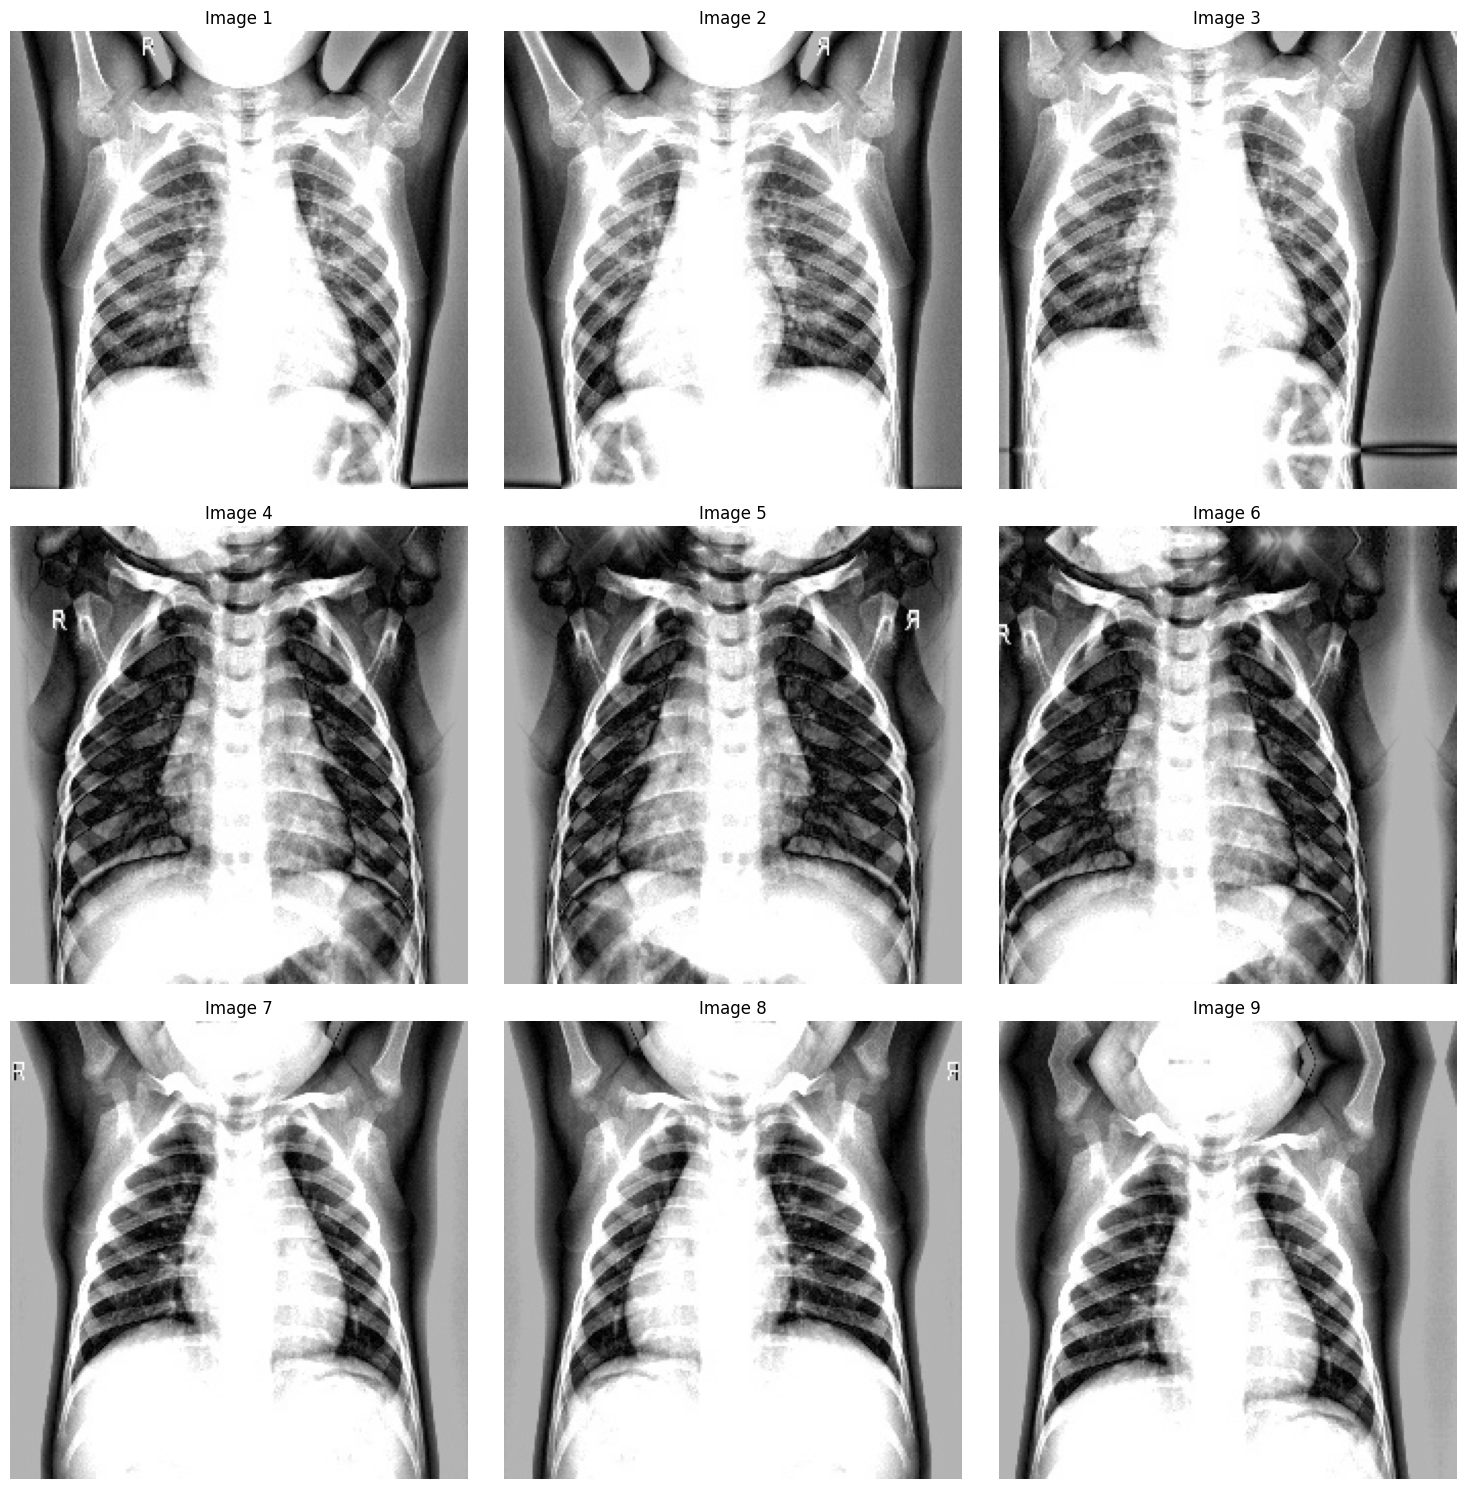

In [42]:
show_images_in_3x3_grid(images_to_show)